# Clustering Schoolwork——Markov Cluster Algorithm on Iris Dataset
### milestone 2
#### author：Hsu An      2016011434
#### last update: 20 Nov 2018


update：
1. 尝试其他距离度量方式（Manhattan距离）
2. 改进过程函数化，使代码解耦合，便于调参
3. 改进聚类性能

基本思路：
1. 使用欧式距离度量计算每个样本之间的相似度，求出矩阵（概率矩阵）
2. 卡阈值，剔除距离过大的值（去掉边）
3. 将剔除过大的值后将矩阵转化为无向图
4. normalize矩阵，并进行迭代（Expansion，Inflation）
5. 当矩阵趋于稳定时，将结果转化为聚簇

## 一、导入必要的算法包

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from pandas.tools.plotting import radviz

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import sklearn.preprocessing

from scipy.sparse import isspmatrix, dok_matrix, csc_matrix

from sklearn.metrics import accuracy_score

## 二、导入iris数据集

In [2]:
# 导入iris数据集


iris = load_iris()  # 加载数据集

features = iris.data # 获取属性数据(各种特征值)
labels = iris.target # 获取类别数据（花的分类）
target_names = iris.target_names # 获取数据的分类名称（花的分类名称）

## 三、原始数据集可视化

[]

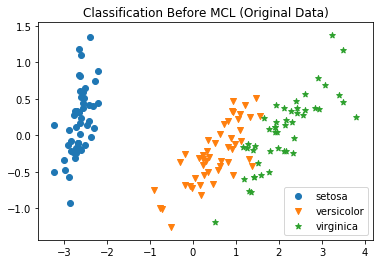

In [3]:
# 使用PCA降维并进行可视化
pca = PCA(n_components=2)
pca.fit(features)
features_new = pca.transform(features)
# plt.figure(figsize=[5,5],dpi=200)
features_new_1 = plt.scatter(features_new[0:50, 0], features_new[0:50, 1],marker='o')
features_new_2 = plt.scatter(features_new[51:100, 0], features_new[51:100, 1],marker='v')
features_new_3 = plt.scatter(features_new[101:149, 0], features_new[101:149, 1],marker='*')
plt.legend(handles=[features_new_1, features_new_2,features_new_3], labels=['setosa', 'versicolor', 'virginica'],  loc='best')
plt.title('Classification Before MCL (Original Data)')
plt.plot()

## 四、求相似度矩阵

In [4]:
# 求相似度矩阵
simple_size = 150 # simple_size定义样本的数量
sim_arr = [] # sim_arr定义相似度列表
for i in features:
    for j in features:
        distance = np.abs(i[0]-j[0])+np.abs(i[1]-j[1])+np.abs(i[2]-j[2])+np.abs(i[3]-j[3])  # 求出每个样本点之间的曼哈顿距离
        sim_arr.append(float(distance))  # 将欧式距离转化为float类型,并添加到list中
sim_arr = np.array(sim_arr) # 将list转化为np.array类型
sim_arr = sim_arr.reshape(simple_size,simple_size) # 将相似度列表转化为150*150的矩阵形式

In [5]:
# 设定阈值，将距离大于阈值的边全部剔除，小于等于阈值且不等于阈值（不加自环）的边设置权重为1（转化为无向图）
threshold = 1.5  # 设定阈值

for i in range(simple_size):
    for j in range(simple_size):
        if sim_arr[i][j] > threshold:
            sim_arr[i][j] = 0
        if sim_arr[i][j] < threshold and sim_arr[i][j] != 0:
            sim_arr[i][j] = 1

In [6]:
# 添加自环
for i in range(simple_size):
    sim_arr[i][i] = 1

In [7]:
# 矩阵标准化
def normalize(matrix):

#     功能：将给定矩阵的行进行标准化
#     输入参数：
#         martix:给定矩阵
#     输出：
#         标准化后的矩阵martix'

    return sklearn.preprocessing.normalize(matrix,norm="l1", axis=0)

In [8]:
# 矩阵相乘操作(Expansion)
def dot_multiply(matrix):
#     功能：将给定矩阵进行乘法
#     输入参数：
#         martix:给定矩阵
#     输出：
#         相乘后的矩阵martix'
    return np.dot(matrix,matrix)

In [9]:
# 矩阵膨胀操作（Inflation）
def inflation(matrix,inflat_factor):
#    功能：将给定矩阵进行膨胀操作(先对矩阵做inflat_factor次乘方，之后标准化矩阵)
#    输入参数：
#         martix:给定矩阵
#         inflat_factor:膨胀算子，将矩阵的每一个元素进行inflat_factor次乘方
#      输出：
#          膨胀后的矩阵martix'
    matrix_inflation = np.power(matrix,inflat_factor) # 将矩阵每个元素进行inflat_factor乘方
    matrix_inflation = normalize(matrix_inflation)  # 将乘方好的矩阵进行标准化处理
    
    return matrix_inflation

In [10]:
# 判断矩阵是否收敛
def matrix_converge(matrix1,matrix2,rtol=1e-05, atol=1e-08):
#    功能：判断矩阵是否收敛
#    输入参数：
#         matrix1:给定矩阵1
#         matrix2:给定矩阵2
#         rtol=1e-05, atol=1e-08：宽容度
#      输出：
#         bool类型，如果收敛，返回true，否则返回false
#          
    return np.allclose(matrix1,matrix2,rtol=rtol, atol=atol)

## 五、迭代邻接矩阵

In [11]:
# 计算带权邻接矩阵
iterate_num = 100 # 指定迭代次数
inflat_factors = 1.8 # 指定膨胀系数

sim_arr_last = sim_arr  # sim_arr_last表示上一次迭代时的矩阵

sim_arr = normalize(sim_arr) # 将矩阵标准化处理

for i in range(iterate_num): # 进行iterate_num次迭代
    sim_arr = dot_multiply(sim_arr)  # 进行矩阵相乘操作
    sim_arr = inflation(sim_arr,inflat_factor=inflat_factors)  # 进行膨胀操作
    if matrix_converge(sim_arr,sim_arr_last):  # 当迭代到相似度基本一致时（基本收敛），提前停止迭代过程
        print('The iteration processed for '+str(i+1)+' rounds')
        print('Iteration has stopped. The best iteration time is '+str(i+1)+".")
        break
    else:
        sim_arr_last = sim_arr
        print('The iteration processed for '+str(i+1)+' rounds')
print('The Adjacency matrix has been converged.')

The iteration processed for 1 rounds
The iteration processed for 2 rounds
The iteration processed for 3 rounds
The iteration processed for 4 rounds
The iteration processed for 5 rounds
The iteration processed for 6 rounds
The iteration processed for 7 rounds
The iteration processed for 8 rounds
The iteration processed for 9 rounds
The iteration processed for 10 rounds
The iteration processed for 11 rounds
The iteration processed for 12 rounds
The iteration processed for 13 rounds
The iteration processed for 14 rounds
The iteration processed for 15 rounds
The iteration processed for 16 rounds
The iteration processed for 17 rounds
The iteration processed for 18 rounds
The iteration processed for 19 rounds
The iteration processed for 20 rounds
The iteration processed for 21 rounds
The iteration processed for 22 rounds
Iteration has stopped. The best iteration time is 22.
The Adjacency matrix has been converged.


## 六、将邻接矩阵转化为聚类

In [12]:
# 将邻接矩阵转化为聚类  best distance = 1.3 inflat_factors = 3  len(cluster_result) = 3   acc = 0.76
def get_clusters(matrix):

    if not isspmatrix(matrix):
        # cast to sparse so that we don't need to handle different 
        # matrix types
        matrix = csc_matrix(matrix)

    # get the attractors - non-zero elements of the matrix diagonal
    attractors = matrix.diagonal().nonzero()[0]

    # somewhere to put the clusters
    clusters = set()

    # the nodes in the same row as each attractor form a cluster
    for attractor in attractors:
        cluster = tuple(matrix.getrow(attractor).nonzero()[1].tolist())
        clusters.add(cluster)

    return sorted(list(clusters))

In [13]:
# 输出聚类结果
cluster_result = get_clusters(sim_arr)
len(cluster_result)
for index,i in enumerate(cluster_result):
    print('Cluster '+str(index+1)+':')
    print(i)
    print('The num in cluster is '+str(len(i)))

Cluster 1:
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49)
The num in cluster is 50
Cluster 2:
(50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 106, 113, 119, 121, 123, 126, 127, 133, 134, 138, 142, 146, 149)
The num in cluster is 63
Cluster 3:
(77, 100, 102, 103, 104, 108, 109, 110, 111, 112, 114, 115, 116, 120, 124, 128, 129, 132, 136, 137, 139, 140, 141, 143, 144, 145, 147, 148)
The num in cluster is 28
Cluster 4:
(105, 107, 117, 118, 122, 125, 130, 131, 135)
The num in cluster is 9


In [14]:
# 整理聚类结果
cluster_index_0 = np.array(cluster_result[0])
cluster_index_1 = np.array(cluster_result[1])
cluster_index_2 = np.array(cluster_result[2])
cluster_index_3 = np.array(cluster_result[3])

In [15]:
# 聚类后标签列表
cluster_lable = np.zeros(150) # 初始化标签列表,全部置为0

for i in cluster_index_0:
    cluster_lable[i] = 0
for i in cluster_index_1:
    cluster_lable[i] = 1
for i in cluster_index_2:
    cluster_lable[i] = 2  
for i in cluster_index_3:
    cluster_lable[i] = 3  

## 七、聚类结果可视化

[]

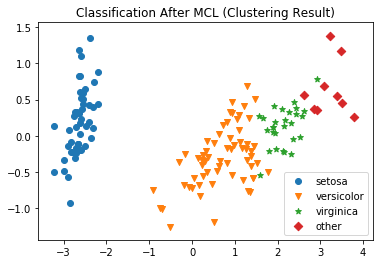

In [19]:
# 使用PCA降维并将聚类结果进行可视化

# 初始化聚类数据坐标列表
cluster_data_0 = np.zeros(shape=(len(cluster_index_0),2))
cluster_data_1 = np.zeros(shape=(len(cluster_index_1),2))
cluster_data_2 = np.zeros(shape=(len(cluster_index_2),2))
cluster_data_3 = np.zeros(shape=(len(cluster_index_3),2))
# 将聚类结果的坐标添加到列表中
for index,i in enumerate(cluster_index_0):
    cluster_data_0[index] = features_new[i]
for index,i in enumerate(cluster_index_1):
    cluster_data_1[index] = features_new[i]
for index,i in enumerate(cluster_index_2):
    cluster_data_2[index] = features_new[i]
for index,i in enumerate(cluster_index_3):
    cluster_data_3[index] = features_new[i]
# 绘制图像
# plt.figure(figsize=[5,5],dpi=200)
features_new_1 = plt.scatter(cluster_data_0[:, 0], cluster_data_0[:, 1],marker='o')
features_new_2 = plt.scatter(cluster_data_1[:, 0], cluster_data_1[:, 1],marker='v')
features_new_3 = plt.scatter(cluster_data_2[:, 0], cluster_data_2[:, 1],marker='*')
features_new_4 = plt.scatter(cluster_data_3[:, 0], cluster_data_3[:, 1],marker='D')
plt.legend(handles=[features_new_1, features_new_2,features_new_3,features_new_4], labels=['setosa', 'versicolor', 'virginica','other'], loc='best')
plt.title('Classification After MCL (Clustering Result)')
plt.plot()

## 八、聚类结果评价

In [17]:
# 输出聚类准确率
acc = accuracy_score(labels,cluster_lable)
print('The MCL accuracy is '+str(acc))

The MCL accuracy is 0.84
